# Load data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Training dataset creation

### Output data

In [3]:
Qstar = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_star.zarr", engine="zarr", chunks={}
)
Qstar

<xarray.Dataset> Size: 14GB
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

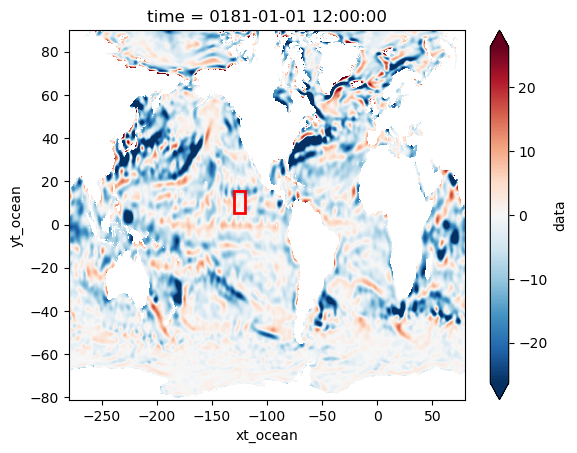

In [6]:
Qstar.data.isel(time=0).plot(robust=True)

lat_min, lat_max = 5.54134386, 15.36255392  # Replace with your actual values
lon_min, lon_max = -129.95, -119.95  # Replace with your actual values

# Draw the box on the plot
plt.gca().add_patch(
    plt.Rectangle(
        (lon_min, lat_min),  # (x, y) start point
        lon_max - lon_min,   # width
        lat_max - lat_min,   # height
        fill=False,          # don't fill the box
        edgecolor='red',     # color of the box
        linewidth=2
    )
)

# Show the plot
plt.show()

In [4]:
Qstar_sample = Qstar.isel(time=slice(0,365), xt_ocean=slice(1500,1600), yt_ocean=slice(1300,1400))
Qstar_sample

<xarray.Dataset> Size: 15MB
Dimensions:   (time: 365, yt_ocean: 100, xt_ocean: 100)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>

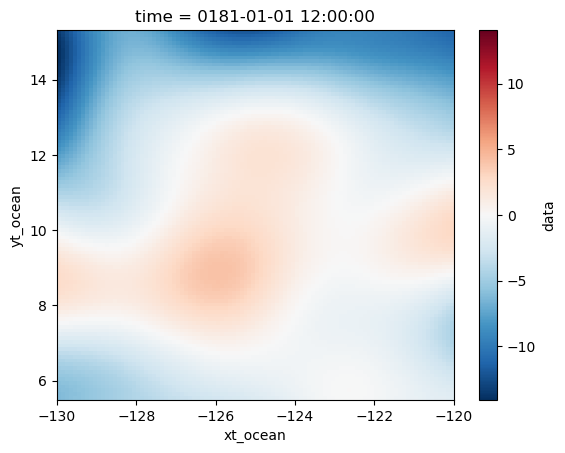

In [5]:
Qstar_sample.data.isel(time=0).plot()

In [6]:
Qstar_halo = Qstar_sample.isel(time=slice(0,11), xt_ocean=slice(0,3), yt_ocean=slice(0,3)) 
Qstar_halo

<xarray.Dataset> Size: 532B
Dimensions:   (time: 11, yt_ocean: 3, xt_ocean: 3)
Coordinates:
  * time      (time) object 88B 0181-01-01 12:00:00 ... 0181-01-11 12:00:00
  * xt_ocean  (xt_ocean) float64 24B -130.0 -129.9 -129.8
  * yt_ocean  (yt_ocean) float64 24B 5.541 5.641 5.74
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>

In [7]:
Qstar_stacked = Qstar_halo.stack(spatial=['xt_ocean', 'yt_ocean'])
Qstar_stacked

<xarray.Dataset> Size: 700B
Dimensions:   (time: 11, spatial: 9)
Coordinates:
  * time      (time) object 88B 0181-01-01 12:00:00 ... 0181-01-11 12:00:00
  * spatial   (spatial) object 72B MultiIndex
  * xt_ocean  (spatial) float64 72B -130.0 -130.0 -130.0 ... -129.8 -129.8
  * yt_ocean  (spatial) float64 72B 5.541 5.641 5.74 5.541 ... 5.541 5.641 5.74
Data variables:
    data      (time, spatial) float32 396B dask.array<chunksize=(3, 9), meta=np.ndarray>

### Input data

In [8]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

ds_lowRes = ds_out.isel(time=slice(0,365), xt_ocean=slice(1500,1600), yt_ocean=slice(1300,1400))
ds_lowRes

Filtering model


<xarray.Dataset> Size: 161MB
Dimensions:       (time: 365, xt_ocean: 100, yt_ocean: 100)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean      (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [9]:
ds_lowRes_halo = ds_lowRes.isel(time=slice(0,11), xt_ocean=slice(0,3), yt_ocean=slice(0,3))
ds_lowRes_halo

<xarray.Dataset> Size: 4kB
Dimensions:       (time: 11, xt_ocean: 3, yt_ocean: 3)
Coordinates:
  * time          (time) object 88B 0181-01-01 12:00:00 ... 0181-01-11 12:00:00
  * xt_ocean      (xt_ocean) float64 24B -130.0 -129.9 -129.8
  * yt_ocean      (yt_ocean) float64 24B 5.541 5.641 5.74
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 396B dask.array<chunksize=(3, 3, 3), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [10]:
u_rel_stacked = ds_lowRes_halo.u_relative.stack(spatial=['xt_ocean', 'yt_ocean'])
v_rel_stacked = ds_lowRes_halo.v_relative.stack(spatial=['xt_ocean', 'yt_ocean'])
sst_stacked = ds_lowRes_halo.surface_temp.stack(spatial=['xt_ocean', 'yt_ocean'])
t_ref_stacked = ds_lowRes_halo.t_ref.stack(spatial=['xt_ocean', 'yt_ocean'])

## NN architecture setup

In [11]:
class SGS_HF(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 8)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(8, 4)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(4, 1)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x
 
model = SGS_HF()
print(model)

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [15]:
print(model)

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [16]:
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
n_epochs = 3
batch_size = 9

for epoch in range(n_epochs):
    for i in range(0, 70, batch_size): #look at enumerate function for index, i
        index = i // batch_size
        
        # Prepare batch data
        x_urel = torch.tensor(u_rel_stacked.isel(time=index).values, dtype=torch.float32)
        x_vrel = torch.tensor(v_rel_stacked.isel(time=index).values, dtype=torch.float32)
        x_sst = torch.tensor(sst_stacked.isel(time=index).values, dtype=torch.float32)
        x_tref = torch.tensor(t_ref_stacked.isel(time=index).values, dtype=torch.float32)
        
        # Concatenate features along the feature dimension (dim=1)
        Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)
        
        # Forward pass
        y_pred = model(Xbatch) 
        
        # Prepare target data
        ybatch = torch.tensor(Qstar_stacked.isel(time=index).data.values, dtype=torch.float32)
        
        # Compute loss
        loss = loss_fn(y_pred.squeeze(), ybatch)  

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients (backpropagation)
        optimizer.step()       # Update model parameters
        
        print(f'Batch {i // batch_size}, loss {loss.item()}')
        
    print(f'Finished epoch {epoch}, latest loss {loss.item()}')


Batch 0, loss 1.6867972612380981
Batch 1, loss 5.210153579711914
Batch 2, loss 0.13580039143562317
Batch 3, loss 3.8070590496063232
Batch 4, loss 2.730724811553955
Batch 5, loss 0.2973734736442566
Batch 6, loss 24.427379608154297
Batch 7, loss 31.196651458740234
Finished epoch 0, latest loss 31.196651458740234
Batch 0, loss 0.3770090341567993
Batch 1, loss 0.6825374364852905
Batch 2, loss 1.9022170305252075
Batch 3, loss 1.5626744031906128
Batch 4, loss 4.023197650909424
Batch 5, loss 0.4911024272441864
Batch 6, loss 23.57155418395996
Batch 7, loss 31.146955490112305
Finished epoch 1, latest loss 31.146955490112305
Batch 0, loss 0.31380611658096313
Batch 1, loss 0.871125340461731
Batch 2, loss 1.5183756351470947
Batch 3, loss 2.0439372062683105
Batch 4, loss 3.2725021839141846
Batch 5, loss 0.2399596869945526
Batch 6, loss 26.74601936340332
Batch 7, loss 26.686079025268555
Finished epoch 2, latest loss 26.686079025268555


In [19]:
torch.save(model.state_dict(), 'leap-persistent/panalluri/airSeaNN_temporal.pth')

In [20]:
torch.save(model, 'leap-persistent/panalluri/airSeaNN_temporal_wholeModel.pth')

## NN training losses

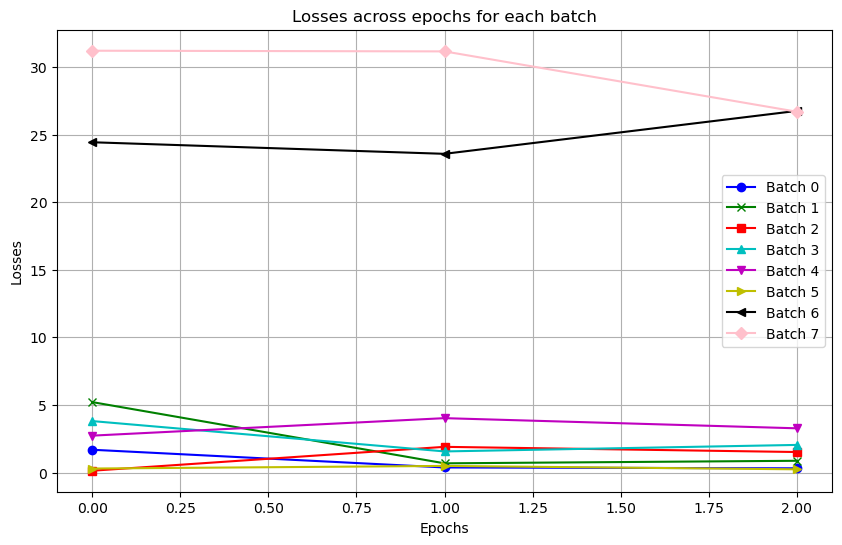

In [41]:
# Example data for multiple lines
epochs = [0, 1, 2]
batch_0_losses = np.array([1.6868, 0.3770, 0.3138])
batch_1_losses = np.array([5.2102, 0.6825, 0.8711])
batch_2_losses = np.array([0.1358, 1.9022, 1.5184])
batch_3_losses = np.array([3.8071, 1.5627, 2.0439])
batch_4_losses = np.array([2.7307, 4.0232, 3.2725])
batch_5_losses = np.array([0.2974, 0.4911, 0.2400])
batch_6_losses = np.array([24.4274, 23.5716, 26.7460])
batch_7_losses = np.array([31.1967, 31.1470, 26.6861])

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(epochs, batch_0_losses, marker='o', color='b', label='Batch 0')  
plt.plot(epochs, batch_1_losses, marker='x', color='g', label='Batch 1')  
plt.plot(epochs, batch_2_losses, marker='s', color='r', label='Batch 2') 
plt.plot(epochs, batch_3_losses, marker='^', color='c', label='Batch 3')  
plt.plot(epochs, batch_4_losses, marker='v', color='m', label='Batch 4')  
plt.plot(epochs, batch_5_losses, marker='>', color='y', label='Batch 5') 
plt.plot(epochs, batch_6_losses, marker='<', color='k', label='Batch 6')  
plt.plot(epochs, batch_7_losses, marker='D', color='pink', label='Batch 7')   

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses across epochs for each batch')
plt.legend()  # Add legend to distinguish lines
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()


## Evaluate NN performance

### Trial 1

In [12]:
model = SGS_HF()  # Recreate the model instance
model.load_state_dict(torch.load('leap-persistent/panalluri/airSeaNN_temporal.pth'))
model.eval()  # Set the model to evaluation mode

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)

In [13]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_stacked.isel(time=8).data.values, dtype=torch.float32)
y_true

tensor([-22.7881, -23.2886, -23.7266, -21.8767, -22.3571, -22.7773, -20.9902,
        -21.4496, -21.8518])

In [14]:
# input info for NN
x_urel = torch.tensor(u_rel_stacked.isel(time=8).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel_stacked.isel(time=8).values, dtype=torch.float32)
x_sst = torch.tensor(sst_stacked.isel(time=8).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref_stacked.isel(time=8).values, dtype=torch.float32)
        
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

In [15]:
with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

In [16]:
# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 257.4769592285156
Mean Absolute Error: 16.02436637878418
R-squared: -367.8670349121094


### Plot comparison

In [18]:
import matplotlib.gridspec as gridspec

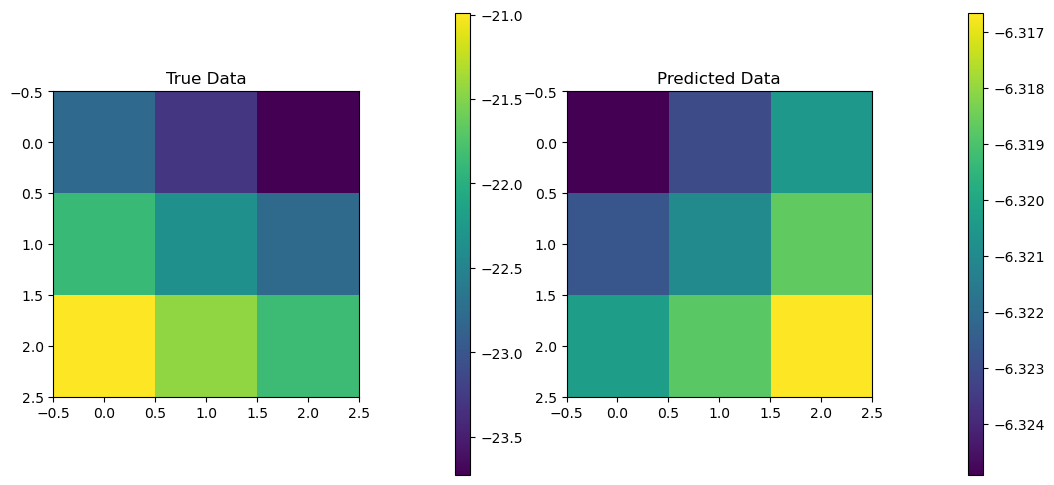

In [19]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Trial 2

In [20]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_stacked.isel(time=9).data.values, dtype=torch.float32)

# input info for NN
x_urel = torch.tensor(u_rel_stacked.isel(time=9).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel_stacked.isel(time=9).values, dtype=torch.float32)
x_sst = torch.tensor(sst_stacked.isel(time=9).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref_stacked.isel(time=9).values, dtype=torch.float32)
        
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 19.150434494018555
Mean Absolute Error: 4.370053291320801
R-squared: -349.7537841796875


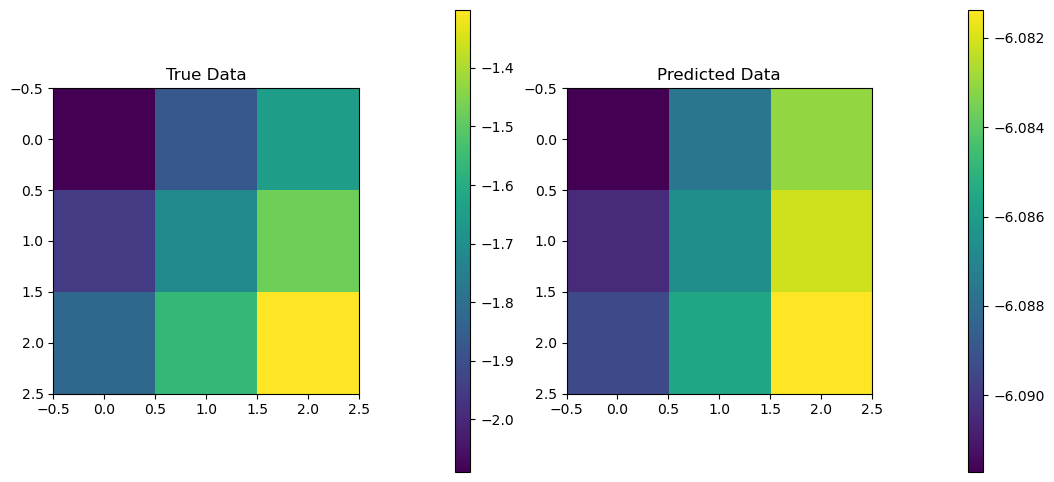

In [21]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Trial 3

In [22]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_stacked.isel(time=10).data.values, dtype=torch.float32)

# input info for NN
x_urel = torch.tensor(u_rel_stacked.isel(time=10).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel_stacked.isel(time=10).values, dtype=torch.float32)
x_sst = torch.tensor(sst_stacked.isel(time=10).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref_stacked.isel(time=10).values, dtype=torch.float32)
        
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 97.55026245117188
Mean Absolute Error: 9.867952346801758
R-squared: -549.0772705078125


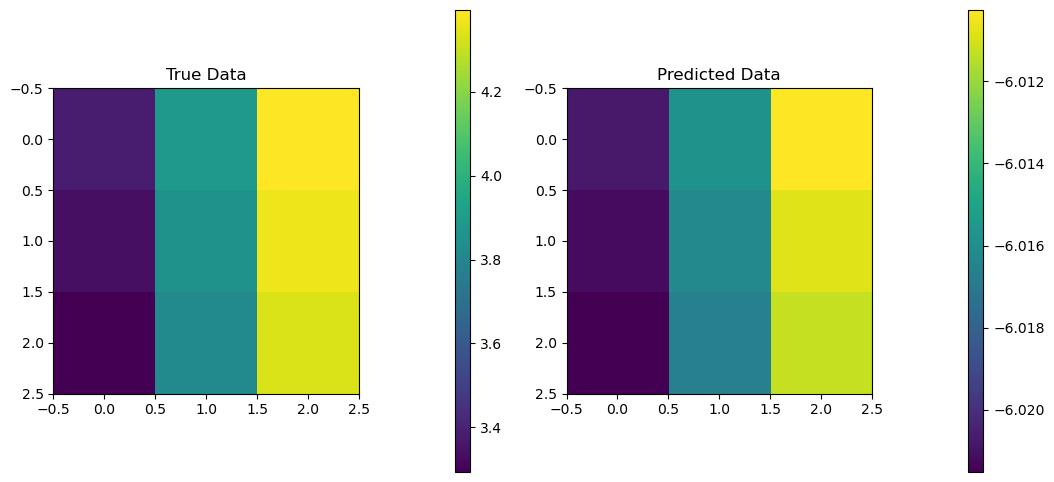

In [23]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
